# This notebook makes predictions
It reads in the optimal number of adjacent wells training file, trains the classifier, investigates which features appear to be the most important to the classifier, reads in the subsurface dataset, makes predictions, plots the predictions in embedded T-SNE space, and then saves the spatial location of the predictions for each formation.

In [1]:
import ternary
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import pdist, squareform
from geopandas import GeoDataFrame
from shapely.geometry import Point
sns.set()

In [2]:
def flatten(container):
    "Flattens lists"
    for i in container:
        if isinstance(i, (list, tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i

In [3]:
%matplotlib inline

Define some colors and colormaps

In [4]:
TRUNCATION_COLOR = "#ffffbf"
ONLAP_COLOR = "#2c7bb6"
HORIZ_COLOR = "#d7191c"
 

truncCmap = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", TRUNCATION_COLOR])
onlapCmap = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", ONLAP_COLOR])
horizCmap = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", HORIZ_COLOR])

Set the number of adjacent wells and read in the correct training dataset then split it

In [5]:
NO_OF_NEIGHBORS = 25

In [6]:
# Dataset inside the training folder at https://osf.io/a6cwh/
DATASET = pd.read_csv(
    str(NO_OF_NEIGHBORS) + "neighbors.csv",
    index_col=[0],
)


X_train, X_test, y_train, y_test = train_test_split(
    DATASET.drop("class", axis=1),
    DATASET["class"],
    test_size=0.2,  
    random_state=86,
)

Train the classifier with optimal parameters

In [7]:
NEIGH = KNeighborsClassifier(
    algorithm="ball_tree",
    leaf_size=10,
    metric="manhattan",
    metric_params=None,
    n_jobs=None,
    n_neighbors=5,
    p=2,
    weights="distance",
)
NEIGH.fit(X_train, y_train)
NEIGH.score(X_test, y_test)

0.9453703703703704

Investigate which features are the most important for high accuracy in the classification

In [8]:
INITIAL = ["thickness", "thickness natural log", "thickness power"]
FEATURES = []
for item in INITIAL:
    FEATURES.append(item)
    for i in range(1, NO_OF_NEIGHBORS + 1):
        FEATURES.append(item + " neighbor " + str(i))
FEATURES.append(["x location", "y location", "class"])
FLAT_FEATURES = list(flatten(FEATURES))

In [9]:
THICKENED = FLAT_FEATURES[0 : NO_OF_NEIGHBORS + 1]
THICKENED.append("class")
LOGGED = FLAT_FEATURES[NO_OF_NEIGHBORS + 1 : 2 * NO_OF_NEIGHBORS + 2]
LOGGED.append("class")
POWERED = FLAT_FEATURES[2 * NO_OF_NEIGHBORS + 2 : 3 * NO_OF_NEIGHBORS + 3]
POWERED.append("class")
LOCATION = ["x location", "y location", "class"]
OG_THICKNESS = ["thickness", "class"]

Drop each feature group and retrain the classifier

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    DATASET.drop(THICKENED, axis=1),
    DATASET["class"],
    test_size=0.2, 
    random_state=86,
)
NEIGH.fit(X_train, y_train)
THICKNESS_REMOVED = NEIGH.score(X_test, y_test)
print(f"Without thickness accuracy is {THICKNESS_REMOVED:.3f}")


X_train, X_test, y_train, y_test = train_test_split(
    DATASET.drop(LOGGED, axis=1),
    DATASET["class"],
    test_size=0.2,  
    random_state=86,
)
NEIGH.fit(X_train, y_train)
LN_REMOVED = NEIGH.score(X_test, y_test)
print(f"Without natural log. Accuracy is {LN_REMOVED:.2f}")

X_train, X_test, y_train, y_test = train_test_split(
    DATASET.drop(POWERED, axis=1),
    DATASET["class"],
    test_size=0.2,  
    random_state=86,
)
NEIGH.fit(X_train, y_train)
POWER_REMOVED = NEIGH.score(X_test, y_test)
print(f"Without power accuracy is {POWER_REMOVED:.2f}")

X_train, X_test, y_train, y_test = train_test_split(
    DATASET.drop(LOCATION, axis=1),
    DATASET["class"],
    test_size=0.2,  
    random_state=86,
)
NEIGH.fit(X_train, y_train)
LOCATION_REMOVED = NEIGH.score(X_test, y_test)
print(f"Without location accuracy is {LOCATION_REMOVED:.2f}")

X_train, X_test, y_train, y_test = train_test_split(
    DATASET.drop(OG_THICKNESS, axis=1),
    DATASET["class"],
    test_size=0.2,  
    random_state=86,
)
NEIGH.fit(X_train, y_train)
OG_T_REMOVED = NEIGH.score(X_test, y_test)
print(f"Done with well thickness. Accuracy is {OG_T_REMOVED:.2f}")

Without thickness accuracy is 0.949
Without natural log. Accuracy is 0.81
Without power accuracy is 0.94
Without location accuracy is 0.93
Done with well thickness. Accuracy is 0.94


Now retrain the classifier again to make predictions on the subsurface dataset

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    DATASET.drop("class", axis=1),
    DATASET["class"],
    test_size=0.2,  
    random_state=86,
)
NEIGH = KNeighborsClassifier(
    algorithm="ball_tree",
    leaf_size=10,
    metric="manhattan",
    metric_params=None,
    n_jobs=None,
    n_neighbors=5,
    p=2,
    weights="distance",
)
NEIGH.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

Read in the subsurface dataset and create a list of the tops

In [12]:
# Dataset at https://osf.io/a6cwh/
TOPS_API = pd.read_csv(
    r"subsurface_data.csv"
).fillna(
    0
)  
ITERABLE = ["Kfh", "Kl", "Tfu"]
TOPCOMBOS = list(zip(ITERABLE, ITERABLE[1:]))

## Making predictions on the subsurface dataset
This runs the subsurface dataset through feature engineering and makes predictions for both the Lance and Fort Union formations

In [13]:
# Dataset at https://osf.io/a6cwh/
RESULTS = []
NORM_ALL = []
PROBS_ALL = []
FULL_PROBS = []

for j in enumerate(TOPCOMBOS):
    print(TOPCOMBOS[j[0]])
    TOPS_API = pd.read_csv(
        r"subsurface_data.csv"
    ).fillna(
        0
    )  
    fmtops = list(TOPCOMBOS[j[0]])
    fmtops.extend(["x", "y"])
    tops = TOPS_API[fmtops]

    # calculate thicknesses and neighbors for the two tops
    hood = squareform(pdist(tops.iloc[:, -2:]))
    neighbors = []
    for i in enumerate(hood.argsort()[0:, 1 : NO_OF_NEIGHBORS + 1]):
        selected = (
            tops.iloc[hood.argsort()[i[0], 1 : NO_OF_NEIGHBORS + 1], 0:-2]
            .stack()
            .to_frame()
            .T
        )
        selected.columns = selected.columns.droplevel()
        neighbors.append(selected)
    frame = pd.concat(neighbors, sort=False)
    frame.index = range(len(frame))
    neighborhood = pd.concat([tops.iloc[:, :-2], frame], axis=1)
    thicknesses = neighborhood.diff(axis=1) * -1
    thicknesses[thicknesses < 0] = 0
    thicknesses.drop(columns=tops.columns[0], inplace=True)
    thicknesses[thicknesses < 0] = 0
    thicknesses[thicknesses > 3000] = 0
    locations = tops[["x", "y"]]
    real_world_log = thicknesses.apply(
        np.log
    )  # take the log of thicknesses for feature engineering
    real_world_pow = thicknesses.apply(
        lambda x: x ** 10
    )  # calculates the power values of thickness for another feature
    rw = (
        pd.concat(
            [thicknesses, real_world_log, real_world_pow, locations],
            axis=1,
        )
        .reindex(thicknesses.index)
        .dropna()
        .replace(-np.inf, 0)
    )
    normalized_rw = (rw - rw.min()) / (rw.max() - rw.min()).replace(
        0, 0.00001
    )  # normalize the data from 0 to 1
    real_data = normalized_rw.values

    well_preds = NEIGH.predict(real_data)  # knn predictions
    well_prob = NEIGH.predict_proba(real_data)  # knn predictions
    FULL_PROBS.append(well_prob)
    probs = []
    for i in range(len(well_prob)):
        probs.append(well_prob[i].max())
    PROBS_ALL.append(probs)
    RESULTS.append(well_preds)
    NORM_ALL.append(normalized_rw)

('Kfh', 'Kl')


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


('Kl', 'Tfu')


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


Data organization and sorting into the different formations

In [14]:
NORMALIZED_KL = NORM_ALL[0]
NORMALIZED_TFU = NORM_ALL[1]

NORMALIZED_KL.columns = DATASET.columns[0:-1].values
NORMALIZED_KL["class"] = RESULTS[0]
NORMALIZED_KL["prob"] = PROBS_ALL[0]

NORMALIZED_TFU.columns = DATASET.columns[0:-1].values
NORMALIZED_TFU["class"] = RESULTS[1]
NORMALIZED_TFU["prob"] = PROBS_ALL[1]


NORMALIZED_KL["Formation"] = "Kl"  # this is lance
NORMALIZED_TFU["Formation"] = "Tfu"  # this is ft union

DF_COMBINED = NORMALIZED_KL
DF_COMBINED1 = DF_COMBINED.append(NORMALIZED_TFU, sort=False)

## Now let's project the predictions down to 2D with T-SNE

In [15]:
DF_SUBSET1 = DF_COMBINED1.drop(["class", "Formation", "prob"], axis=1)
tsne = TSNE(
    n_components=2,
    verbose=0.2,
    perplexity=50,
    n_iter=1500,
    learning_rate=500,
    random_state=20,
)  
TSNE_RESULTS = tsne.fit_transform(DF_SUBSET1)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1776 samples in 0.022s...
[t-SNE] Computed neighbors for 1776 samples in 0.384s...
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.812218
[t-SNE] KL divergence after 1500 iterations: 1.236310


Split out the three different classes and plot them up with their probabilities of each class

In [16]:
PROBABILITIES = np.vstack(FULL_PROBS)

DF_COMBINED1["trunc_prob"] = PROBABILITIES[:, 0]
DF_COMBINED1["onlap_prob"] = PROBABILITIES[:, 1]
DF_COMBINED1["horiz_prob"] = PROBABILITIES[:, 2]

First for truncation

Text(0, 0.5, 't-SNE Dimension 2')

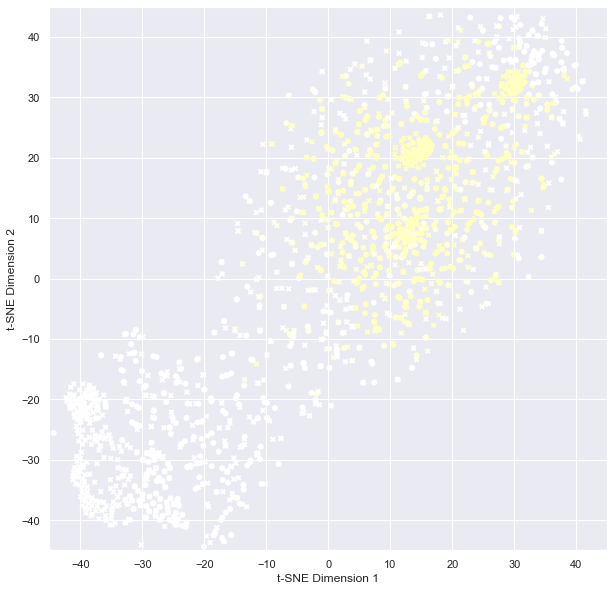

In [17]:
DF_COMBINED1["tsne-2d-one"] = TSNE_RESULTS[:, 0]
DF_COMBINED1["tsne-2d-two"] = TSNE_RESULTS[:, 1]
color_pals = ["#ffffbf", "#2c7bb6", "#d7191c"]

# 0 is truncation, 1 is onlap, 2 is horizontal

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=DF_COMBINED1["tsne-2d-one"],
    y=DF_COMBINED1["tsne-2d-two"],
    hue=DF_COMBINED1["trunc_prob"],
    style=DF_COMBINED1["Formation"],
    palette=truncCmap,
    data=DF_COMBINED1,
    legend=None,
    alpha=1,
    edgecolor="none",
    vmin=-1,
    vmax=1,
)
plt.xlim(-45, 45)
plt.ylim(-45, 45)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
# plt.savefig('tsne_trunc.pdf')

Now for onlap

(-45, 45)

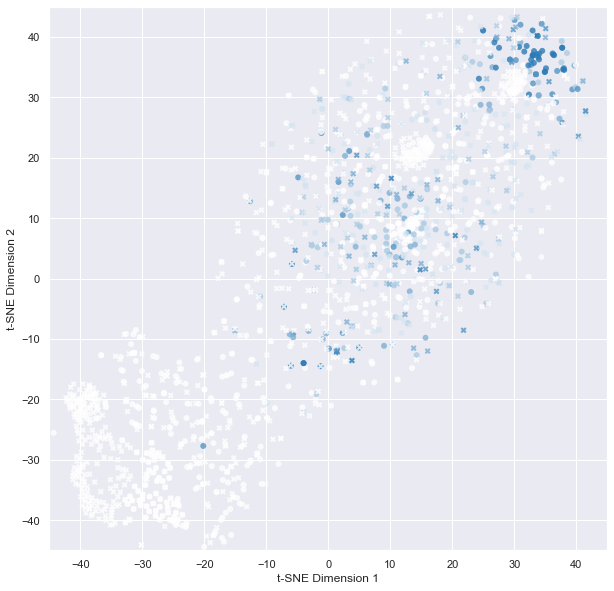

In [18]:
plt.figure(figsize=(10, 10))

sns.scatterplot(
    x=DF_COMBINED1["tsne-2d-one"],
    y=DF_COMBINED1["tsne-2d-two"],
    hue=DF_COMBINED1["onlap_prob"],
    style=DF_COMBINED1["Formation"],
    palette=onlapCmap,
    data=DF_COMBINED1,
    legend=None,
    alpha=0.8,
    edgecolor="none",
)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.xlim(-45, 45)
plt.ylim(-45, 45)
# plt.savefig('tsne_onlap.pdf')

Lastly horizontally stratified

(-45, 45)

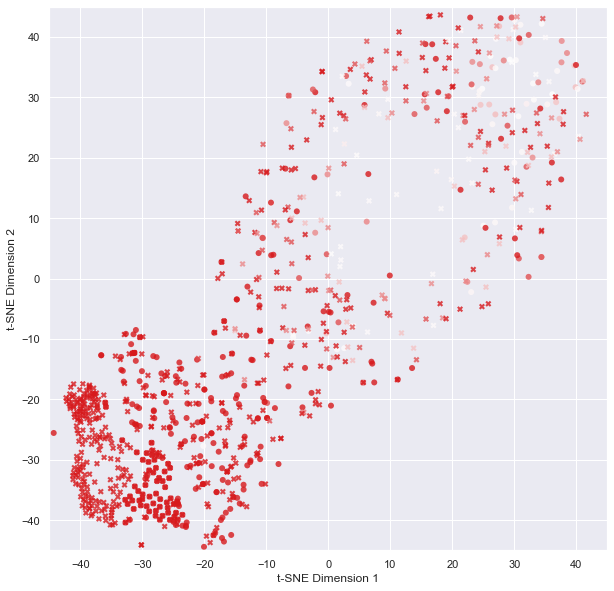

In [19]:
HORIZONTALS = DF_COMBINED1[(DF_COMBINED1.horiz_prob > 0.0)]
plt.figure(figsize=(10, 10))

sns.scatterplot(
    x=HORIZONTALS["tsne-2d-one"],
    y=HORIZONTALS["tsne-2d-two"],
    hue=HORIZONTALS["horiz_prob"],
    style=HORIZONTALS["Formation"],
    palette=horizCmap,
    data=HORIZONTALS,
    legend=None,
    alpha=0.8,
    edgecolor="none",
    vmin=0,
    vmax=1,
)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.xlim(-45, 45)
plt.ylim(-45, 45)
# plt.savefig('tsne_horiz.pdf')

Next, we want to add in locations to the well predictions

In [20]:
x_locs = TOPS_API.x.append(TOPS_API.x, ignore_index=True)
y_locs = TOPS_API.y.append(TOPS_API.y, ignore_index=True)
API = TOPS_API.API.append(TOPS_API.API, ignore_index=True)

DF_COMBINED1["x_locs"] = x_locs
DF_COMBINED1["y_locs"] = y_locs
DF_COMBINED1["api"] = API

And split them out by formation

In [21]:
FTUNION = DF_COMBINED1[DF_COMBINED1["Formation"] == "Tfu"]
LANCER = DF_COMBINED1[DF_COMBINED1["Formation"] == "Kl"]

Now we want to save the predictions as a shapefile, these are the shapefiles used in the final figures

In [22]:
geometry = [Point(xy) for xy in zip(FTUNION.x_locs, FTUNION.y_locs)]
crs = {"init": "epsg:3732"}
geo_df = GeoDataFrame(FTUNION, crs={"init": "epsg:4326"}, geometry=geometry)
geo_df.to_file(
    driver="ESRI Shapefile",
    filename=r"FTUNION_KNN_predictions_prob.shp",
 )

geometry = [Point(xy) for xy in zip(LANCER.x_locs, LANCER.y_locs)]
crs = {"init": "epsg:3732"}
geo_df = GeoDataFrame(LANCER, crs={"init": "epsg:4326"}, geometry=geometry)
geo_df.to_file(
    driver="ESRI Shapefile",
    filename=r"lance_KNN_predictions_prob.shp",
 )


Finally we want to make a ternary diagram of the prediction probabilities

(-0.05, 1.05, -0.1, 0.9)

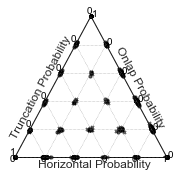

In [23]:

fig, tax = ternary.figure(scale=1)
fig.set_size_inches(3, 3)

tax.scatter(
    LANCER[["trunc_prob", "onlap_prob", "horiz_prob"]].values,
    marker="o",
    alpha=0.6,
    c="black",
    s=10,
)
tax.scatter(
    FTUNION[["trunc_prob", "onlap_prob", "horiz_prob"]].values,
    marker="x",
    alpha=0.6,
    c="black",
    s=10,
)
tax.left_axis_label("Truncation Probability", fontsize=12, offset=0.08)
tax.right_axis_label("Onlap Probability", fontsize=12, offset=0.08)
tax.bottom_axis_label("Horizontal Probability", fontsize=12, offset=-0.08)
tax.get_axes().axis("off")

tax.boundary(linewidth=1)
tax.gridlines(multiple=0.20, color="gray")
tax.ticks(axis="lbr", linewidth=1, multiple=0.20)
tax.get_axes().axis("off")
# plt.savefig('ternary.pdf')